<a href="https://colab.research.google.com/github/avionerman/computational_and_statistical/blob/main/novissimus_extended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries/packages

In [7]:
#!pip install cupy-cuda12x
import os
import time
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp # np alternative for gpu

# scikit lib (cpu) for data loading and metrics only
from sklearn.model_selection import ParameterGrid, StratifiedKFold #datasplitting
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler #standarization with scaler
from scipy.io import loadmat
import seaborn as sns

# cuml alt of sklearn lib with gpu for models & pca
from cuml.svm import LinearSVC, SVC
from cuml.neighbors import KNeighborsClassifier
from cuml.decomposition import PCA as cuPCA
from cuml.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [8]:
DATASET_NAMES = ["COLON", "EUROSAT", "CIFAR10", "SVHN"]
USE_PCA = True # False if PCA is not needed
PCA_VARIANCE = 0.90 # set your own pca variance
RANDOM_STATE = 42 # set your own random state
SHOW_EXAMPLES = True # if you don't want to see visualizations related to the labes & predicted labels set to False

Δημιουργω τη μεταβλητη random state ωστε να χρησ/θει στο PCA - πολλες φορες ο διαχωρισμος train/test και η ιδια η εκπαιδευση των μοντελων περιεχουν στοχαστικα στοιχεια. Ετσι η μεταβλητη βοηθαει ωστε τα αποτελεσματα να μπορουννα γινουν reproduce και compare.

# Custom prep of EUROSAT & COLON HISTO

## Colorectal histology dataset prep

In [9]:
def load_colorectal_histology(resize_to=(48, 48)):
    """
    loading the colorectal_histology dataset from tensorflow dataset
    resize only this dataset to avoid gpu out-of-memory in pca
    """

    import tensorflow_datasets as tfds
    import numpy as np
    import cv2
    from sklearn.model_selection import train_test_split

    print("Loading colorectal_histology from TFDS ...")

    ds, info = tfds.load("colorectal_histology", split="train", with_info=True)

    class_names = info.features["label"].names  # 8 tissue classes

    X = []
    y = []

    for sample in tfds.as_numpy(ds):
        img = sample["image"].astype("float32")
        img = cv2.resize(img, resize_to, interpolation=cv2.INTER_AREA)

        X.append(img)
        y.append(sample["label"])

    X = np.array(X)
    y = np.array(y)

    print(f"Loaded COLON: {X.shape[0]} samples | resized to: {X.shape[1:]}")

    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    return (x_train, y_train), (x_test, y_test), class_names


Εκανα resize τις εικονες γιατι με 96x96 εσκαγε η εκτελεση του PCA. Επισης εκανα mapping τα labels με integers και στο τελος απλως αποθηκευσα τα training & test αντιστοιχα στα x και y.

## EUROSAT dataset prep

In [10]:
def load_eurosat():
    import tensorflow_datasets as tfds
    import numpy as np

    print("Loading EuroSAT...")

    ds_train = tfds.load("eurosat/rgb", split="train", shuffle_files=True)

    X = []
    y = []
    class_names = None

    for sample in tfds.as_numpy(ds_train):
        if class_names is None:
            class_names = sample["label"].__array_interface__["data"]
        X.append(sample["image"])
        y.append(sample["label"])

    X = np.array(X)
    y = np.array(y)

    # 80 / 20 train/test split
    split = int(0.8 * len(X))
    x_train, x_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # class names extract
    info = tfds.builder("eurosat/rgb").info
    class_names = info.features["label"].names

    return (x_train, y_train), (x_test, y_test), class_names


# Data loading

In [44]:
def load_data(dataset_name):
    """
    returns: (x_train, y_train), (x_test, y_test), class_names
    """

    print(f"Loading {dataset_name} ...")

    if dataset_name == "CIFAR10":

        from tensorflow.keras.datasets import cifar10
        from sklearn.model_selection import train_test_split

        (x_train, y_train), (x_test, y_test) = cifar10.load_data()

        y_train = y_train.flatten()
        y_test = y_test.flatten()

        # keep only 10% of the data (stratify keeps class balance)
        #x_train, _, y_train, _ = train_test_split(x_train_full, y_train_full, train_size=1.0, stratify=y_train_full, random_state=42)
        #x_test, _, y_test, _ = train_test_split(x_test_full, y_test_full, train_size=1.0, stratify=y_test_full, random_state=42)

        class_names = [
            "airplane", "automobile", "bird", "cat", "deer",
            "dog", "frog", "horse", "ship", "truck"
        ]

        print(f"Train: {x_train.shape}, Test: {x_test.shape}")

    elif dataset_name == "SVHN":
        def get_svhn_split(split, data_dir="./data"):
            os.makedirs(data_dir, exist_ok=True)
            urls = {
                "train": "http://ufldl.stanford.edu/housenumbers/train_32x32.mat",
                "test":  "http://ufldl.stanford.edu/housenumbers/test_32x32.mat",
            }

            # store the data (if doesn't exist) localy
            filepath = os.path.join(data_dir, urls[split].split("/")[-1])
            if not os.path.exists(filepath):
                print(f"Downloading SVHN {split} set...")
                urllib.request.urlretrieve(urls[split], filepath)

            # from matlab to python dict
            data = loadmat(filepath)
            X = np.transpose(data["X"], (3, 0, 1, 2)) # bringing N first from 4th to 1st idx
            y = data["y"].flatten() # flatten data from (n,1) to (n) - similar to cifar10
            y[y == 10] = 0 # digit 0 has wrong label, would not work right in the next steps
            return X, y

        x_train, y_train = get_svhn_split("train")
        x_test, y_test = get_svhn_split("test")
        class_names = [str(i) for i in range(10)]

    elif dataset_name == "EUROSAT":
      (x_train, y_train), (x_test, y_test), class_names = load_eurosat()

    elif dataset_name == "COLON":
      (x_train, y_train), (x_test, y_test), class_names = load_colorectal_histology()


    else:
        raise ValueError("Invalid DATASET_NAME. Choose 'CIFAR10', 'SVHN', or 'DOTA'.")

    print(f"Dataset Loaded. Train: {x_train.shape}, Test: {x_test.shape}")
    return (x_train, y_train), (x_test, y_test), class_names


Επελεξα τα Histology, EuroSAT, CIFAR-10 και SVHN για να διαφερουν ως προς τον αριθμο δειγματων, τον αριθμο κατηγοριων και τη διαστασιμοτητα. Αυτο μου επιτρεπει να μελετησω τη συμπεριφρα του PCA και των SVMs σε πραγματικα προβληματα υψηλων διαστασεων σε σχεση με πορβληματα μετριων διαστασεων. Κατα αυτον τον τροπο μπορω να δω τη συμβολη του PCA και το ποσο βοηθαει/αποδιδει, ειτε χρονικα ειτε απο καθαρο ζητημα κοστους υπολογισμου.

Οσον αφορα το EuroSAT και COLON datasets, κρατησα το χρωμα αντι να γινουν ασπρομαυρες οι φωτογραφιες (που πιθανον να ηταν πιο ευκολο για αναλυση, ειδικα με pca) γιατι αν χασω το χρωμα τοτε χανω τεραστιο μερος της πληροφοριας γιατι δε θα μπορει να γινουν διακριτες καποιες κομβικης σημασιας γωνιες και σημεια της φωτογραφιας καθως μιλαμε για ιστορολογιεσ φωτογραφιες ή δορυφορικες εικονες. Το χρωμα μπορει να αποτελει ισως και τον νο1 παραγοντα διακριτικοποιησης τους.

# Preprocessing for KPCA

In [12]:
def preprocess_for_kpca(x_train, x_test):
    # flatten and normalize in cpu mode
    print("Flattening data ...")
    print("Normalizing data ...")
    x_train_flat = x_train.reshape(len(x_train), -1).astype("float32") / 255.0
    x_test_flat  = x_test.reshape(len(x_test), -1).astype("float32") / 255.0

    # standardize in cpu mode
    print("Standardizing data ...")
    scaler = StandardScaler() # x_scaled = (x-xmean)/std | mean=0, std=1
    x_train_scaled = scaler.fit_transform(x_train_flat)
    # never fit the test data - data leakage - reuse mean & std from the training data to standarize them
    x_test_scaled  = scaler.transform(x_test_flat)

    return x_train_scaled, x_test_scaled

# Apply KPCA

In [13]:
def apply_kpca(x_train_scaled, x_test_scaled, kernel, n_components, gamma=None):
    # set gamma for rbf/poly/sigmoid kernels
    if gamma is None:
        gamma = 1.0 / x_train_scaled.shape[1]  # default: 1/n_features

    print(f"Applying Kernel PCA (kernel={kernel}, n_components={n_components}) ...")
    kpca = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, random_state=42)
    x_train_kpca = kpca.fit_transform(x_train_scaled)
    x_test_kpca  = kpca.transform(x_test_scaled)

    print(f"KPCA output shape: {x_train_kpca.shape}")

    return x_train_kpca, x_test_kpca, kpca

# Apply LDA

In [14]:
def apply_lda(x_train_kpca, x_test_kpca, y_train):
    # lda max components = min(n_classes - 1, n_features)
    n_classes = len(np.unique(y_train))
    n_components = min(n_classes - 1, x_train_kpca.shape[1])

    print(f"Applying LDA (n_components={n_components}) ...")
    lda = LDA(n_components=n_components)
    x_train_lda = lda.fit_transform(x_train_kpca, y_train)
    x_test_lda  = lda.transform(x_test_kpca)

    print(f"LDA output shape: {x_train_lda.shape}")

    return x_train_lda, x_test_lda, lda

# Run models

In [15]:
# 1
def run_model(model_type, x_train, y_train, x_test, y_test, classes, params=None):
    # imports needed localy since I run them standalone for testing
# 2
    import time
    import numpy as np
    import cupy as cp
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.neighbors import NearestCentroid
    from cuml.svm import LinearSVC, SVC
    from cuml.neighbors import KNeighborsClassifier
    from sklearn.model_selection import ParameterGrid, StratifiedKFold
# 3
    if params is None: params = {}
    print(f"\nRunning {model_type} ...")
    start_time = time.time()

# 4
    # data prep
    # i need cpu mode data so if the data are in gpu mode i transform them, if not ignore
    y_train_cpu = cp.asnumpy(y_train) if hasattr(y_train, 'device') else y_train
    y_test_cpu  = cp.asnumpy(y_test)  if hasattr(y_test, 'device') else y_test

# 5
    # i need gpu mode data so if the data are in cpu mode i transform them, if not ignore
    y_train_gpu = cp.asarray(y_train)
    x_train_gpu = cp.asarray(x_train) if not hasattr(x_train, 'device') else x_train
    x_test_gpu  = cp.asarray(x_test)  if not hasattr(x_test, 'device') else x_test

# 6
    # ncc model prep for cpu execution, NOT gpu (since it's not supported)
    if model_type == "NCC":
        base_clf = NearestCentroid()
        base_clf.fit(cp.asnumpy(x_train_gpu), y_train_cpu)
        best_model = base_clf
        best_params = "Default"
        # compute predictions
        predictions = best_model.predict(cp.asnumpy(x_test_gpu))
        y_train_pred = best_model.predict(cp.asnumpy(x_train_gpu))

# 7
    # define the models and their parameters (given, or if empty set the default i defined)
    else:
        if model_type == "LinearSVC":
            ModelClass = LinearSVC
            grid_params = params if params else {"C": [0.1, 1, 10]}
        elif model_type == "RBF_SVM":
            ModelClass = lambda **k: SVC(kernel="rbf", **k)
            grid_params = params if params else {"C": [1, 10], "gamma": ["scale"]}
        elif model_type == "Poly_SVM":
            ModelClass = lambda **k: SVC(kernel="poly", **k)
            grid_params = params if params else {"C": [1], "degree": [3]}
        elif model_type == "KNN":
            ModelClass = KNeighborsClassifier
            grid_params = params if params else {"n_neighbors": [5, 11]}
        else:
            raise ValueError(f"Unknown model: {model_type}")

# 8
        # robust grid search
        # ie, {"C": [1, 10], "gamma": ["scale"]} or {"C": 1, "gamma": "scale"}
        # for the 1st example, would produce param_keys = ["C"]
        # ignoring the string elements,
        # since should be in the hyperparameters of the model and NOT under the grid parameters (wrong)!
        param_keys = [k for k, v in grid_params.items() if isinstance(v, list)]

        # compute the best model and its params
        # ie, if {"C": 1, "gamma": "scale"} (hyperparameters)
        # then there is no need for grid search
        # so build the model without grid
        if not param_keys:
            best_model = ModelClass(**grid_params)
            best_model.fit(x_train_gpu, y_train_gpu)
            best_params = grid_params

# 9
        # exact opposite ie, {"C": [1, 10], "gamma": ["scale"]} -- multiple values
        # then grid is needed
        else:
            best_score = -1
            # creating a split with 3 folds and shuffled data with a set random state
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

            # creates list of combs - from {"C": [1, 10], "gamma": ["scale", "auto"]}
            # to {"C": 1, "gamma": "scale"}, {"C": 1, "gamma": "auto"}, etc
            param_grid = list(ParameterGrid(grid_params))

            print(f"Grid Search {len(param_grid)} configs...")

# 10
            # simply parsing each parameter from the param_grid list from prev step
            for p in param_grid:
                scores = []

                # loop of 3 folds (stratified - keeping stable ratio per class)
                # 1st: 1+2 validate 3, 2nd: 1+3 validate 2, 3rd: 2+3 validate 1
                for train_idx, val_idx in skf.split(y_train_cpu, y_train_cpu):

                    # build model with parameter p
                    clf = ModelClass(**p)

                    #traing using gpu
                    clf.fit(x_train_gpu[train_idx], y_train_gpu[train_idx])

                    # prediction on each fold
                    preds = clf.predict(x_train_gpu[val_idx])

                    # back to cpu mode
                    # compute acc for each fold and append it to scores
                    scores.append(accuracy_score(cp.asnumpy(y_train_gpu[val_idx]), cp.asnumpy(preds)))

                # pick best hyper combo (avg of folds' acc per p)
                if np.mean(scores) > best_score:
                    best_score = np.mean(scores)
                    best_params = p

# 11
            # execute best model with the best params
            best_model = ModelClass(**best_params)
            best_model.fit(x_train_gpu, y_train_gpu)

# 12
        # get best model values in gpu mode
        y_train_pred_gpu = best_model.predict(x_train_gpu)
        y_train_pred = cp.asnumpy(y_train_pred_gpu)

        # best model calc on gpu mode
        y_test_pred_gpu = best_model.predict(x_test_gpu)

        # move them back to cpu because metrics will need them (metrics run on cpu mode)
        predictions = cp.asnumpy(y_test_pred_gpu)

    elapsed = time.time() - start_time

# 13
    # how well model fits training data
    train_acc = accuracy_score(y_train_cpu, y_train_pred)

# 14
    # how well model generalizes
    test_acc  = accuracy_score(y_test_cpu, predictions)

# 18
    # from the samples i predicted, how many were correct
    precision = precision_score(y_test_cpu, predictions, average='macro', zero_division=0)

# 19
    # from the samples belong to a class, how many I found
    recall = recall_score(y_test_cpu, predictions, average='macro', zero_division=0)

# 20
    # combo of precision and recall (avg for all classes) - balance
    f1 = f1_score(y_test_cpu, predictions, average='macro', zero_division=0)

    # UPDATED PRINT STATEMENT: Shows all metrics immediately
    print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | "
          f"Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f} | "
          f"Time: {elapsed:.2f}s | Params: {best_params}")

    # confusion matrix for each model using
    # test labels, predictions, classes names and the model itself
    plot_confusion_matrix(y_test_cpu, predictions, classes, model_type)

    return {
        "model": model_type,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "time": elapsed,
        "params": best_params,
        "predictions": predictions
    }

# Visualize using Confusion Matrix

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    """

    Small summary: shows us how many times the model had right or not right preds,
    while showing which classes confuses each other too.

    Helps me to visulize the confusion matrix for each model execution.
    The confusion matrix is a table that shows how my classifier performed by
    simply comparing the true labels and the pred labels
    The stronger the diagonical result (darker color) the better the prediction
    If it's not represented in the diagonical then it's an error
    That way I can also detect the confusions (ie, ship is getting confused with trick)

    """

    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    # getting as input the true labels from the test set
    # and the labels predicted from the model
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.title(f"{title} - Confusion Matrix", fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualize Model Comparison

In [17]:
def plot_model_comparison(results_df):
    """

    Line chart comparing all models across all metrics.

    """
    import matplotlib.pyplot as plt

    # metrics definition
    metrics = ['test_acc', 'precision', 'recall', 'f1_score']

    plt.figure(figsize=(12, 6))

    # create line for each model
    for i, row in results_df.iterrows():
        # values of each metric for each row
        y_values = row[metrics].values

        # the line itself accepting the metric, values, and the model
        plt.plot(metrics, y_values, marker='o', linewidth=2, label=row['model'])

        # adding numerical labels for visibility (min-max from 0 to 1)
        for x, y in zip(metrics, y_values):
            plt.text(x, y + 0.01, f"{y:.2f}", fontsize=8, ha='center')

    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.ylabel('Score (0-1)', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Models")
    plt.tight_layout()
    plt.show()

# Main KPCA + LDA

In [42]:
def main_kpca_lda():

    # kernels to test for KPCA
    kernels = ['linear', 'rbf', 'poly']
    DATASET_NAMES = ["CIFAR10"]

    # kpca components
    n_components_kpca = 200

    # models to run on KPCA+LDA features (same as Task A)
    models = [
        ("LinearSVC", {"C": [0.1, 1], "max_iter": [10000]}),
        ("RBF_SVM",   {"C": [1, 10], "gamma": ["scale"]}),
        ("Poly_SVM",  {"C": [1], "degree": [3]}),
        ("KNN",       {"n_neighbors": [5, 10]}),
        ("NCC",       {})
    ]

    all_results = []

    for dataset_name in DATASET_NAMES:

        print("\n" + "="*80)
        print(f"KPCA+LDA RUNNING DATASET: {dataset_name}")
        print("="*80)

        # load data
        (x_tr_raw, y_tr), (x_te_raw, y_te), classes = load_data(dataset_name)

        # preprocess: flatten/normalize/standardize (no PCA)
        x_tr_scaled, x_te_scaled = preprocess_for_kpca(x_tr_raw, x_te_raw)

        # test each KPCA kernel
        for kernel in kernels:
            print(f"\n{'='*60}")
            print(f"KPCA KERNEL: {kernel}")
            print(f"{'='*60}")

            # step 1: kpca
            x_tr_kpca, x_te_kpca, kpca = apply_kpca(x_tr_scaled, x_te_scaled, kernel, n_components_kpca)

            # step 2: lda
            x_tr_lda, x_te_lda, lda = apply_lda(x_tr_kpca, x_te_kpca, y_tr)

            # convert to gpu for cuml models
            x_tr_lda_gpu = cp.asarray(x_tr_lda)
            x_te_lda_gpu = cp.asarray(x_te_lda)

            results = []

            # step 3: run all models on KPCA+LDA features
            for model_name, params in models:
                res = run_model(model_name, x_tr_lda_gpu, y_tr, x_te_lda_gpu, y_te, classes, params)
                res["kpca_kernel"] = kernel
                res["dataset"] = dataset_name
                results.append(res)
                all_results.append(res)

            # summary table for this kernel
            print(f"\n--- Summary for KPCA ({kernel}) + LDA ---")
            df = pd.DataFrame(results)
            summary_cols = ["model", "train_acc", "test_acc", "f1_score", "precision", "recall", "time", "params"]
            print(df[summary_cols].round(4).to_string(index=False))

    return all_results


KPCA+LDA RUNNING DATASET: CIFAR10
Loading CIFAR10 ...
Train: (50000, 32, 32, 3), Test: (10000, 32, 32, 3)
Dataset Loaded. Train: (50000, 32, 32, 3), Test: (10000, 32, 32, 3)
Flattening data ...
Normalizing data ...
Standardizing data ...

KPCA KERNEL: linear
Applying Kernel PCA (kernel=linear, n_components=200) ...
KPCA output shape: (50000, 200)
Applying LDA (n_components=9) ...
LDA output shape: (50000, 9)

Running LinearSVC ...
Grid Search 2 configs...
Train Acc: 0.4158 | Test Acc: 0.4028 | Prec: 0.3947 | Rec: 0.4028 | F1: 0.3894 | Time: 0.22s | Params: {'C': 1, 'max_iter': 10000}


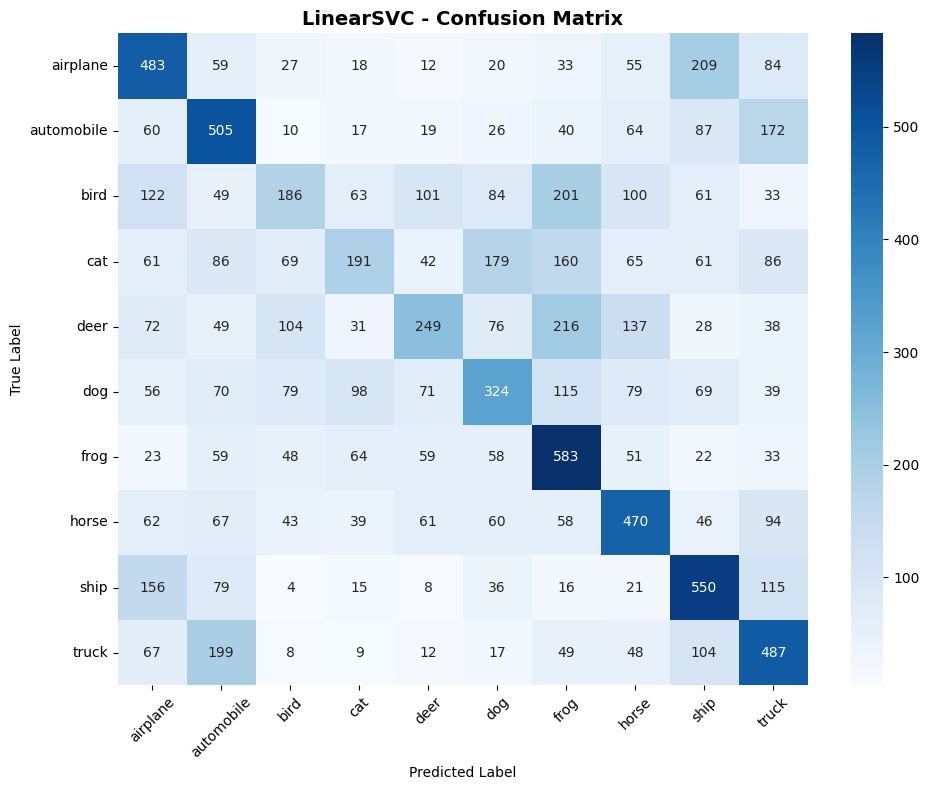


Running RBF_SVM ...
Grid Search 2 configs...
Train Acc: 0.4875 | Test Acc: 0.4459 | Prec: 0.4433 | Rec: 0.4459 | F1: 0.4435 | Time: 41.08s | Params: {'C': 1, 'gamma': 'scale'}


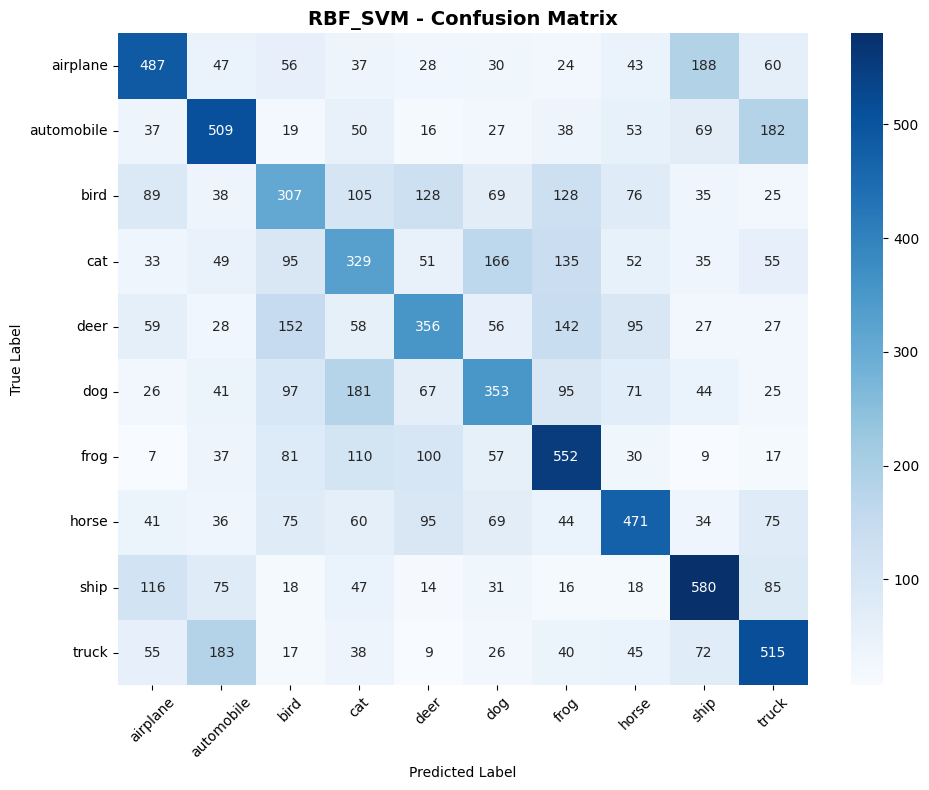


Running Poly_SVM ...
Grid Search 1 configs...
Train Acc: 0.4368 | Test Acc: 0.4132 | Prec: 0.4434 | Rec: 0.4132 | F1: 0.4197 | Time: 62.40s | Params: {'C': 1, 'degree': 3}


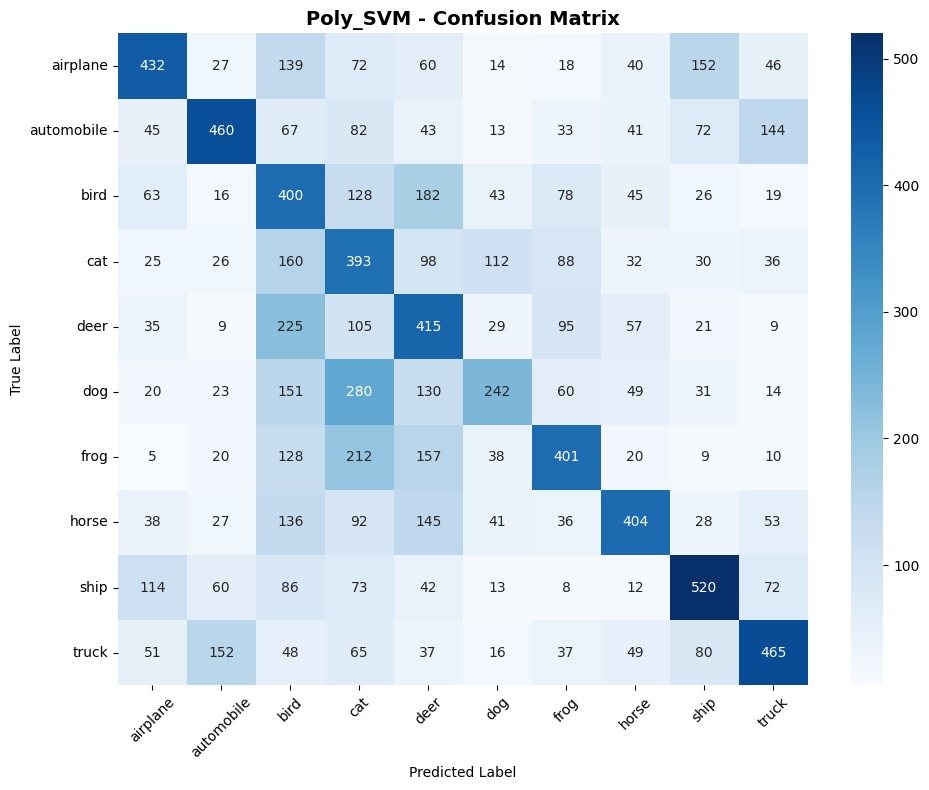


Running KNN ...
Grid Search 2 configs...
Train Acc: 0.5189 | Test Acc: 0.4006 | Prec: 0.4041 | Rec: 0.4006 | F1: 0.4003 | Time: 0.26s | Params: {'n_neighbors': 10}


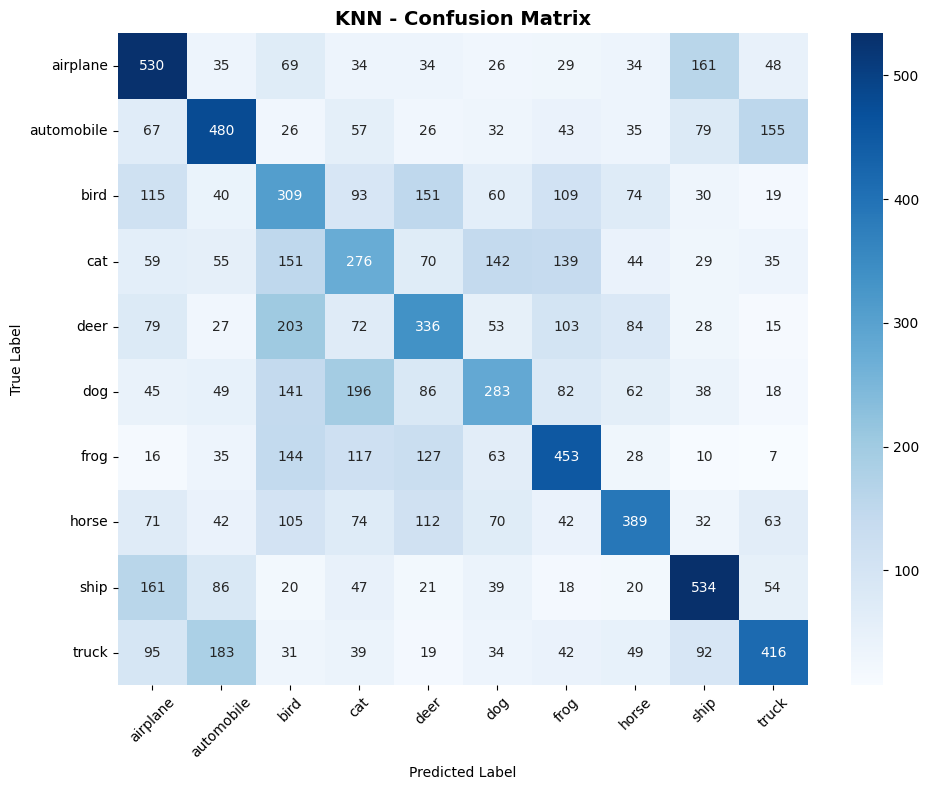


Running NCC ...
Train Acc: 0.4223 | Test Acc: 0.4069 | Prec: 0.4033 | Rec: 0.4069 | F1: 0.4038 | Time: 0.03s | Params: Default


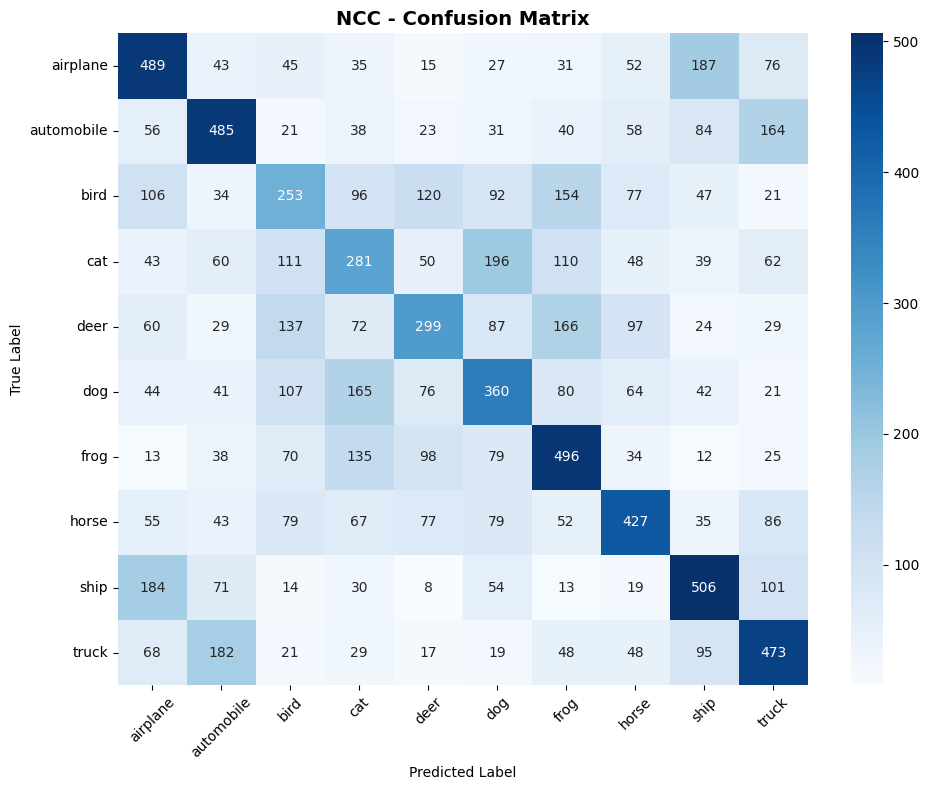


--- Summary for KPCA (linear) + LDA ---
    model  train_acc  test_acc  f1_score  precision  recall    time                      params
LinearSVC     0.4158    0.4028    0.3894     0.3947  0.4028  0.2176 {'C': 1, 'max_iter': 10000}
  RBF_SVM     0.4875    0.4459    0.4435     0.4433  0.4459 41.0835  {'C': 1, 'gamma': 'scale'}
 Poly_SVM     0.4368    0.4132    0.4197     0.4434  0.4132 62.3997       {'C': 1, 'degree': 3}
      KNN     0.5189    0.4006    0.4003     0.4041  0.4006  0.2563         {'n_neighbors': 10}
      NCC     0.4223    0.4069    0.4038     0.4033  0.4069  0.0283                     Default

KPCA KERNEL: rbf
Applying Kernel PCA (kernel=rbf, n_components=200) ...
KPCA output shape: (50000, 200)
Applying LDA (n_components=9) ...
LDA output shape: (50000, 9)

Running LinearSVC ...
Grid Search 2 configs...
Train Acc: 0.4550 | Test Acc: 0.4557 | Prec: 0.4492 | Rec: 0.4557 | F1: 0.4476 | Time: 0.27s | Params: {'C': 0.1, 'max_iter': 10000}


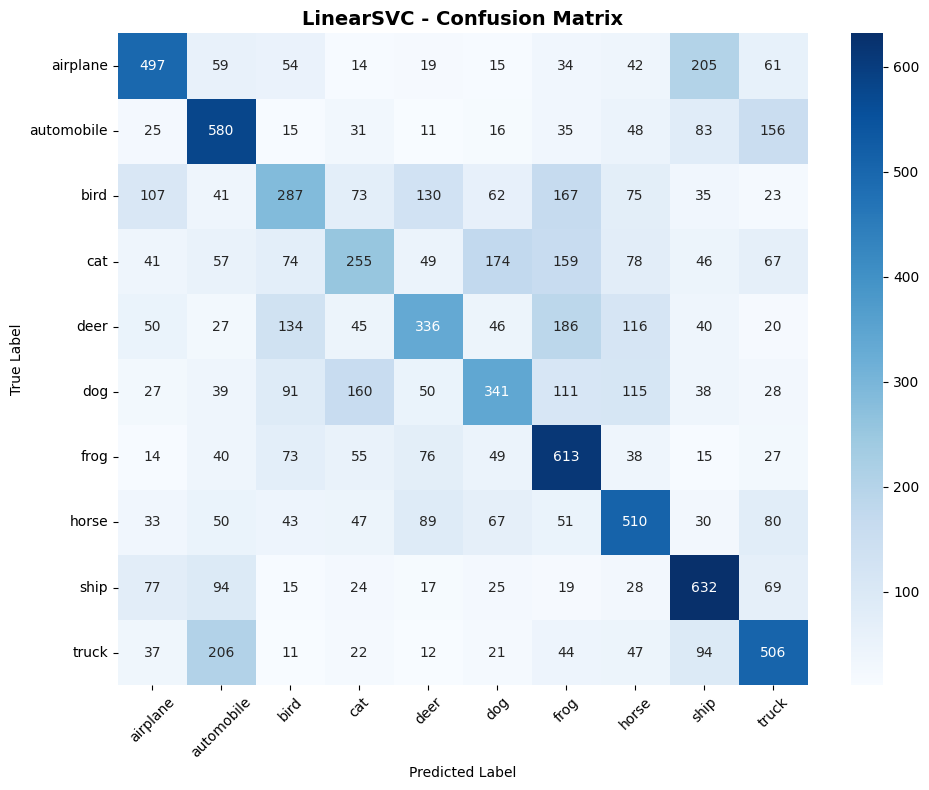


Running RBF_SVM ...
Grid Search 2 configs...
Train Acc: 0.4880 | Test Acc: 0.4728 | Prec: 0.4689 | Rec: 0.4728 | F1: 0.4684 | Time: 36.72s | Params: {'C': 1, 'gamma': 'scale'}


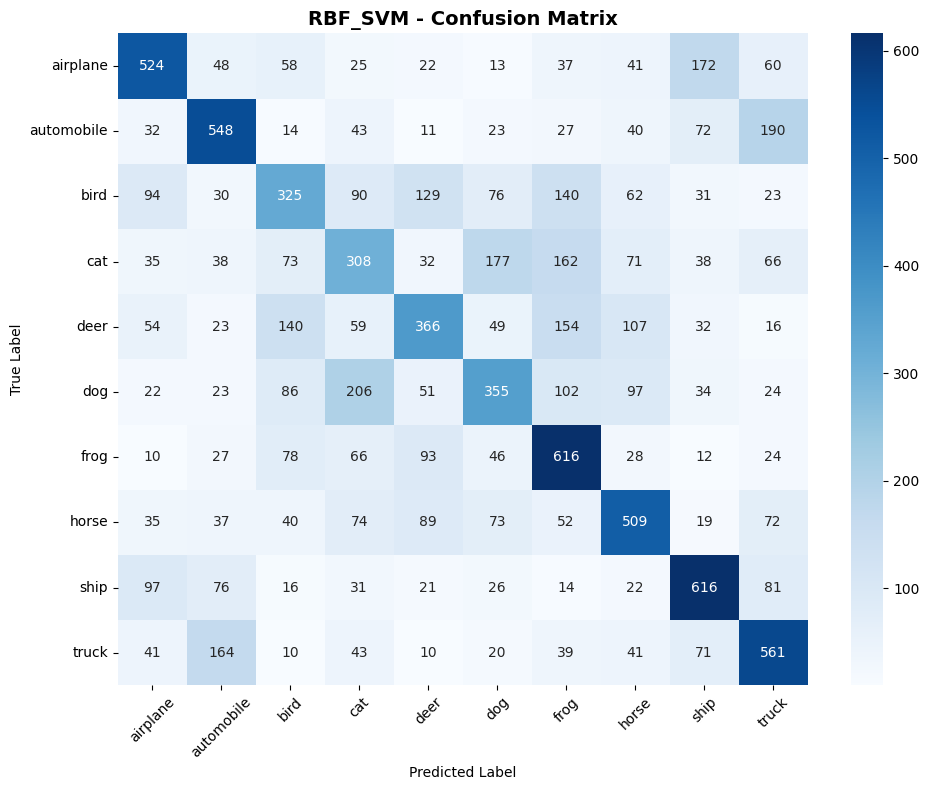


Running Poly_SVM ...
Grid Search 1 configs...
Train Acc: 0.4721 | Test Acc: 0.4616 | Prec: 0.4750 | Rec: 0.4616 | F1: 0.4631 | Time: 48.06s | Params: {'C': 1, 'degree': 3}


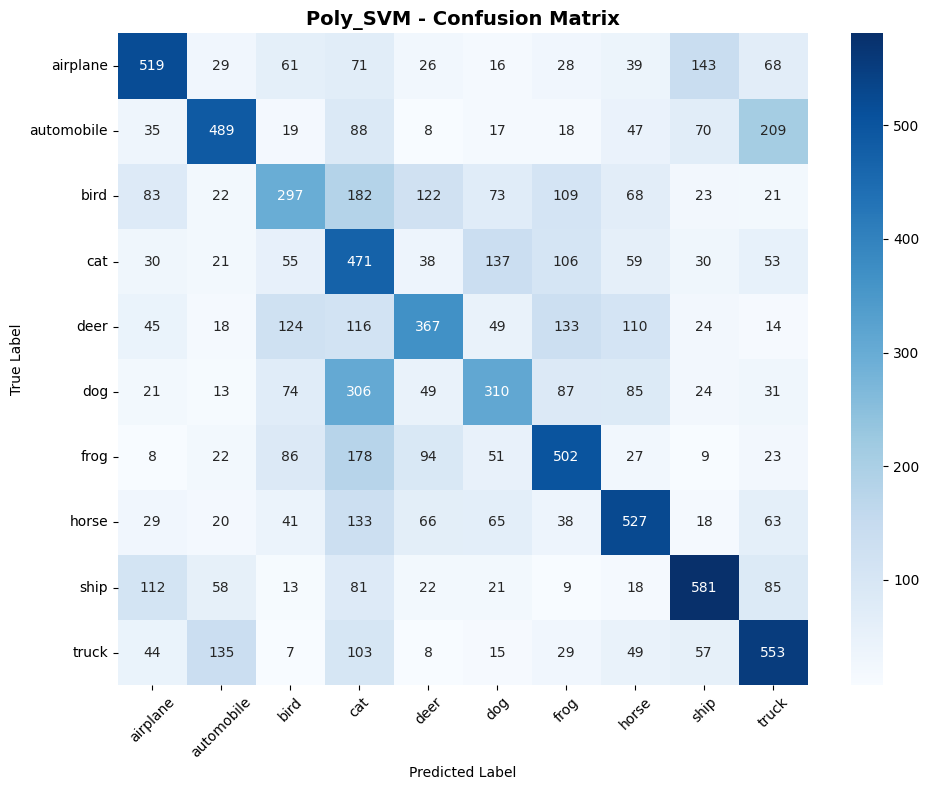


Running KNN ...
Grid Search 2 configs...
Train Acc: 0.5332 | Test Acc: 0.4396 | Prec: 0.4394 | Rec: 0.4396 | F1: 0.4385 | Time: 0.26s | Params: {'n_neighbors': 10}


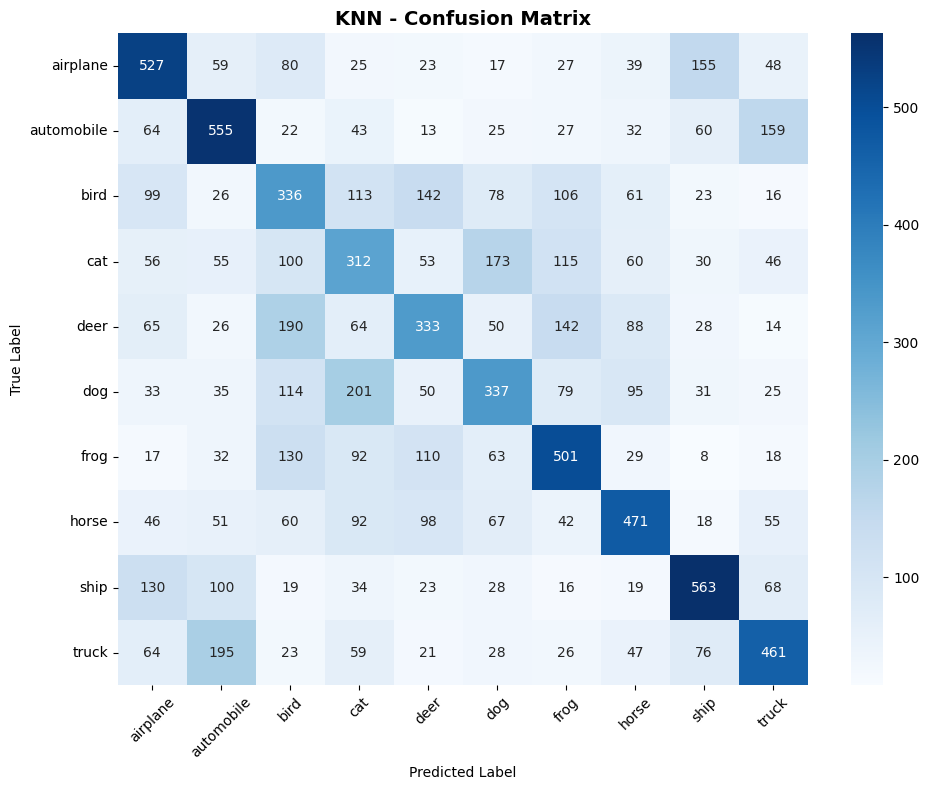


Running NCC ...
Train Acc: 0.4545 | Test Acc: 0.4558 | Prec: 0.4551 | Rec: 0.4558 | F1: 0.4537 | Time: 0.03s | Params: Default


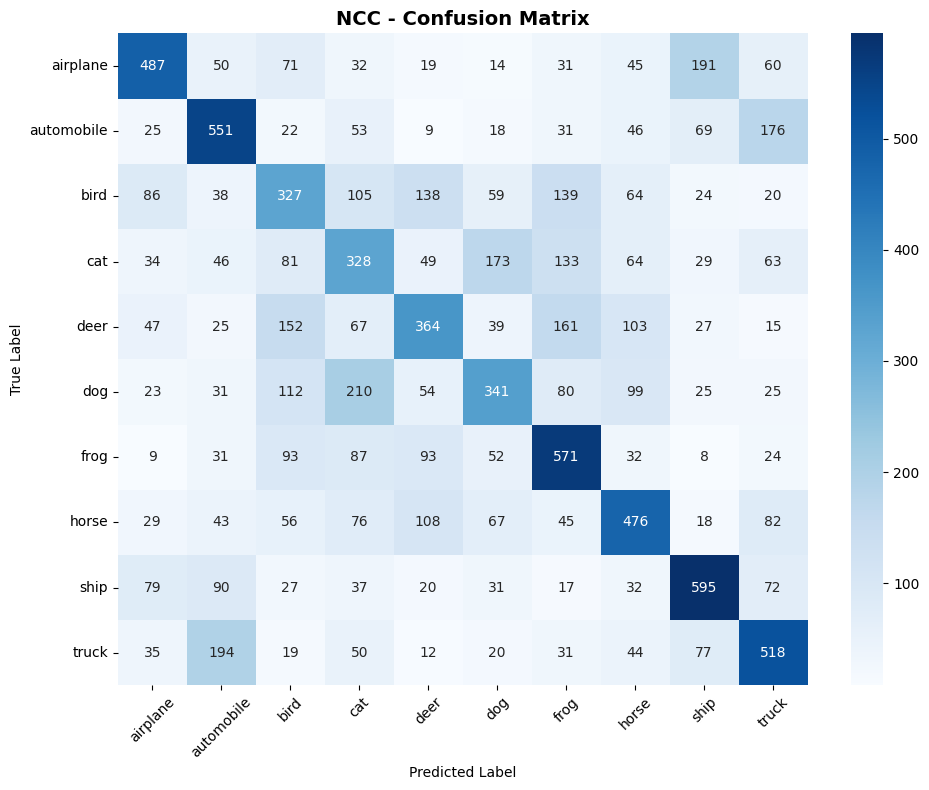


--- Summary for KPCA (rbf) + LDA ---
    model  train_acc  test_acc  f1_score  precision  recall    time                        params
LinearSVC     0.4550    0.4557    0.4476     0.4492  0.4557  0.2707 {'C': 0.1, 'max_iter': 10000}
  RBF_SVM     0.4880    0.4728    0.4684     0.4689  0.4728 36.7216    {'C': 1, 'gamma': 'scale'}
 Poly_SVM     0.4721    0.4616    0.4631     0.4750  0.4616 48.0590         {'C': 1, 'degree': 3}
      KNN     0.5332    0.4396    0.4385     0.4394  0.4396  0.2565           {'n_neighbors': 10}
      NCC     0.4545    0.4558    0.4537     0.4551  0.4558  0.0262                       Default

KPCA KERNEL: poly
Applying Kernel PCA (kernel=poly, n_components=200) ...
KPCA output shape: (50000, 200)
Applying LDA (n_components=9) ...
LDA output shape: (50000, 9)

Running LinearSVC ...
Grid Search 2 configs...
Train Acc: 0.4501 | Test Acc: 0.4458 | Prec: 0.4403 | Rec: 0.4458 | F1: 0.4363 | Time: 0.27s | Params: {'C': 0.1, 'max_iter': 10000}


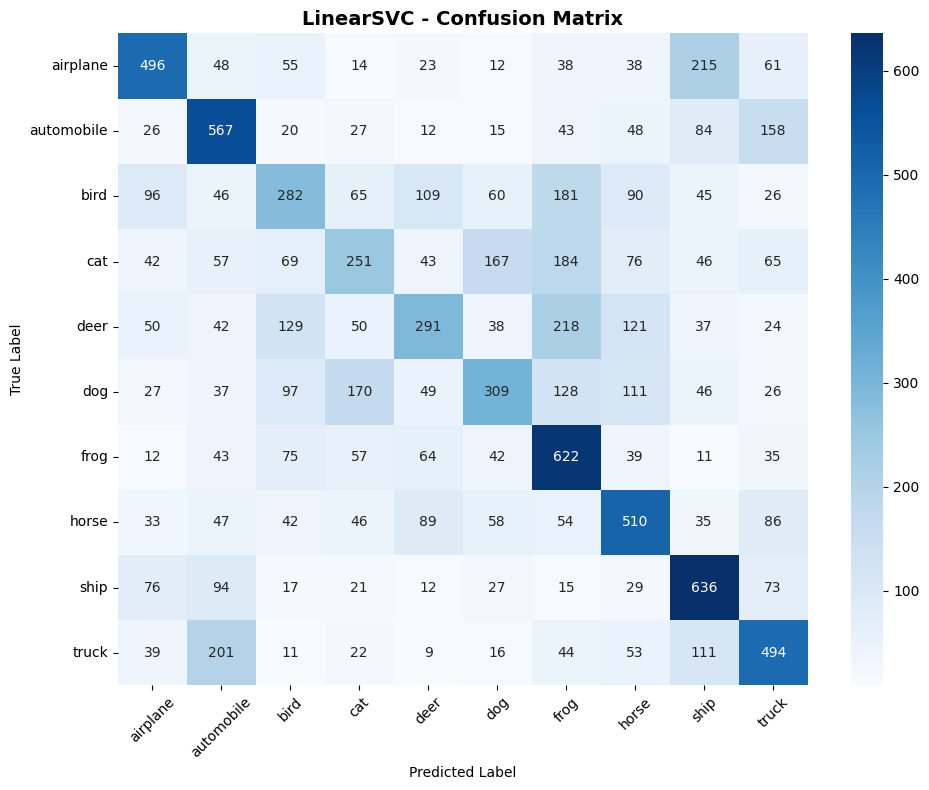


Running RBF_SVM ...
Grid Search 2 configs...
Train Acc: 0.4888 | Test Acc: 0.4708 | Prec: 0.4680 | Rec: 0.4708 | F1: 0.4669 | Time: 36.68s | Params: {'C': 1, 'gamma': 'scale'}


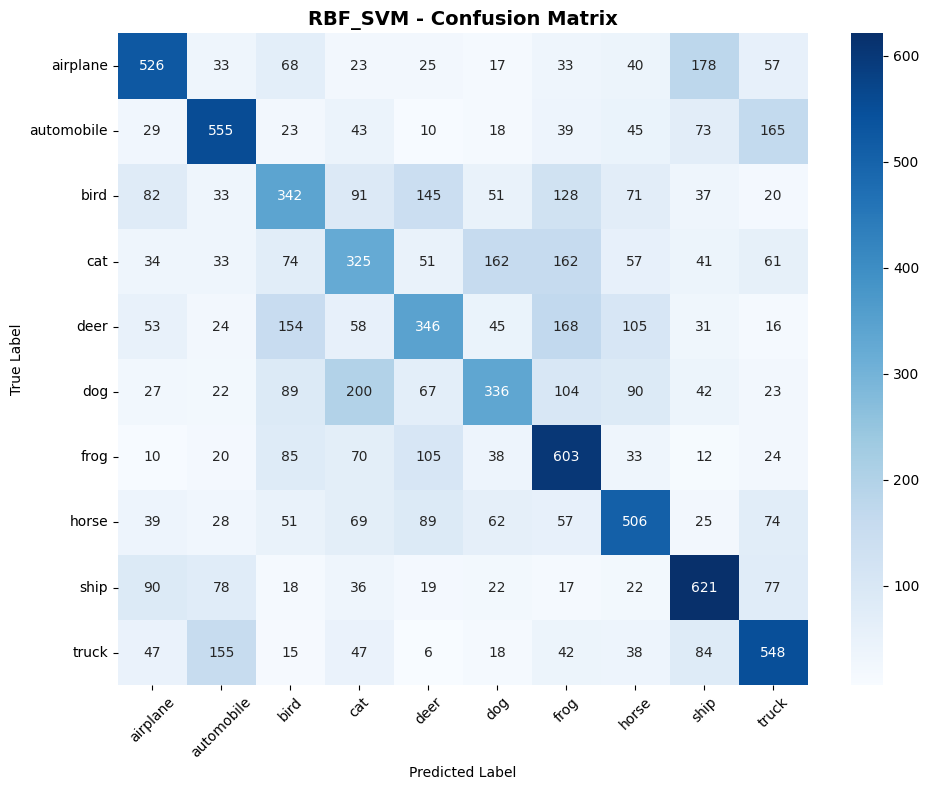


Running Poly_SVM ...
Grid Search 1 configs...
Train Acc: 0.4432 | Test Acc: 0.4289 | Prec: 0.4709 | Rec: 0.4289 | F1: 0.4370 | Time: 58.16s | Params: {'C': 1, 'degree': 3}


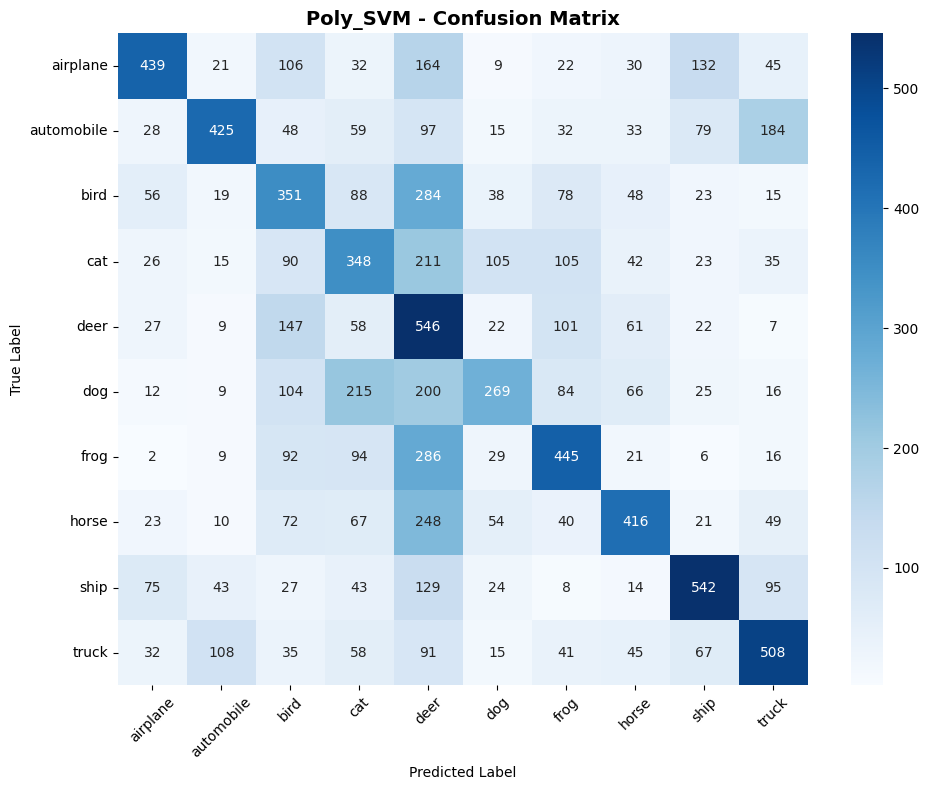


Running KNN ...
Grid Search 2 configs...
Train Acc: 0.5288 | Test Acc: 0.4382 | Prec: 0.4393 | Rec: 0.4382 | F1: 0.4371 | Time: 0.25s | Params: {'n_neighbors': 10}


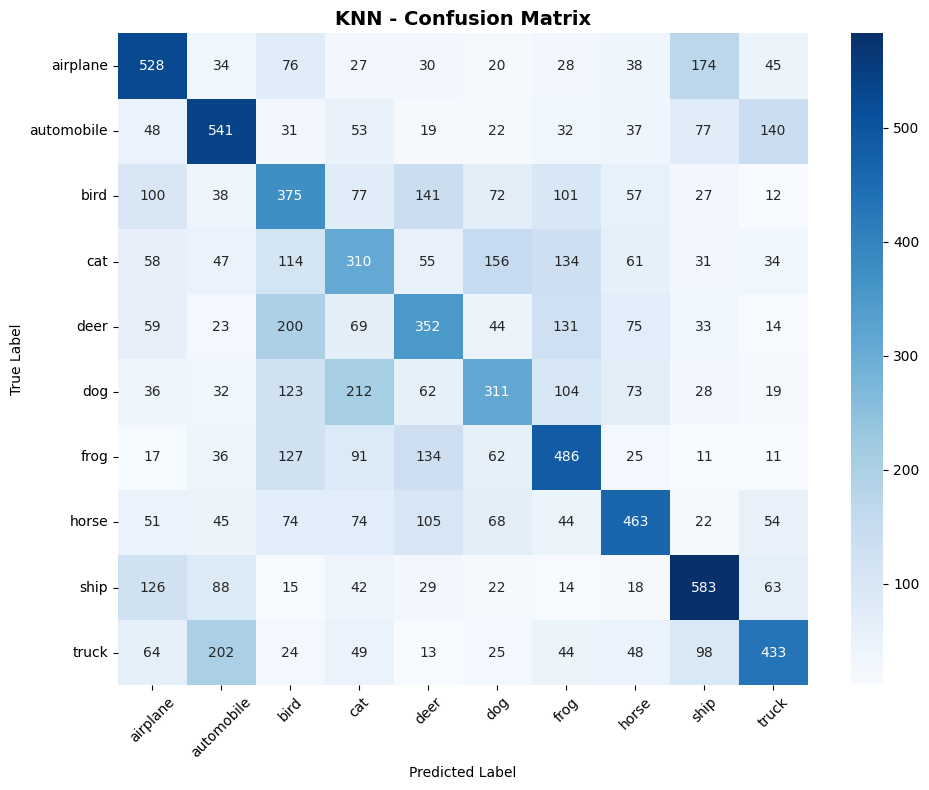


Running NCC ...
Train Acc: 0.4480 | Test Acc: 0.4497 | Prec: 0.4524 | Rec: 0.4497 | F1: 0.4483 | Time: 0.03s | Params: Default


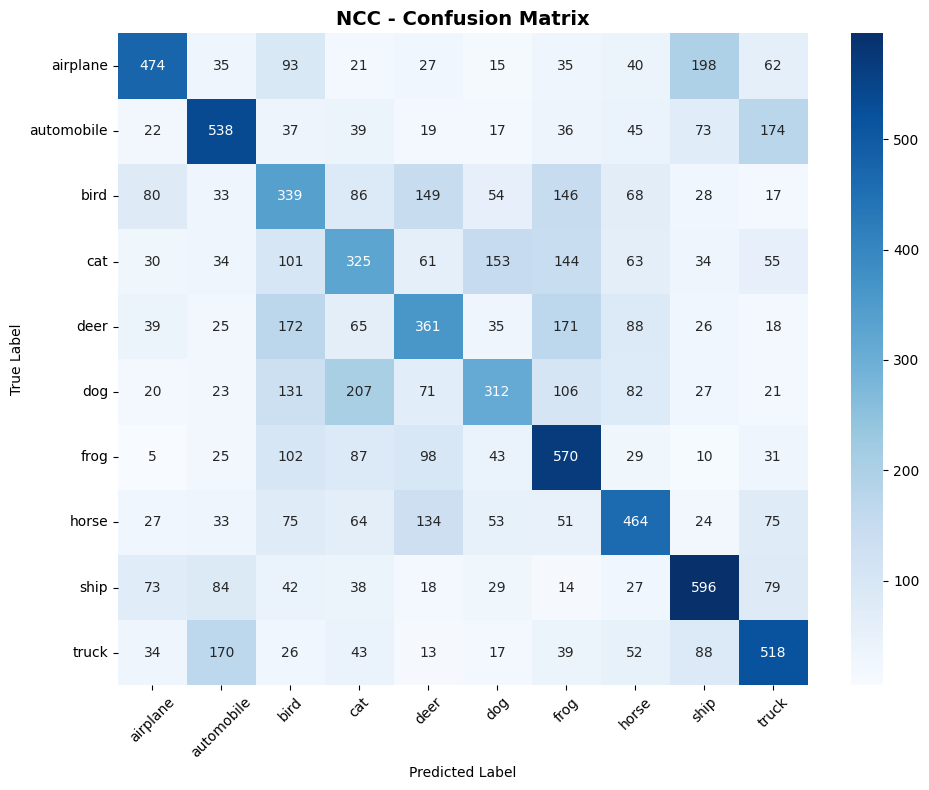


--- Summary for KPCA (poly) + LDA ---
    model  train_acc  test_acc  f1_score  precision  recall    time                        params
LinearSVC     0.4501    0.4458    0.4363     0.4403  0.4458  0.2740 {'C': 0.1, 'max_iter': 10000}
  RBF_SVM     0.4888    0.4708    0.4669     0.4680  0.4708 36.6832    {'C': 1, 'gamma': 'scale'}
 Poly_SVM     0.4432    0.4289    0.4370     0.4709  0.4289 58.1585         {'C': 1, 'degree': 3}
      KNN     0.5288    0.4382    0.4371     0.4393  0.4382  0.2531           {'n_neighbors': 10}
      NCC     0.4480    0.4497    0.4483     0.4524  0.4497  0.0281                       Default


In [45]:
kpca_lda_results = main_kpca_lda()